# Collecting the Data from Alpha Vantage and Patents View API

In [124]:
import dill
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import numpy as np
import scipy as sp

In [466]:
#import previously requested data, if not then use requests. 
patents=dill.load(open("ibm_patents.dill",mode="rb"))
stocks=dill.load(open("ibm_stocks.dill",mode='rb'))

In [467]:
#We will be looking at the adjusted closing price, aggregated monthly.
df_stocks=pd.DataFrame.from_dict(stocks['Monthly Adjusted Time Series'],orient='index')
df_stocks.index = pd.to_datetime(df_stocks.index)
df_stocks['5. adjusted close']=df_stocks['5. adjusted close'].astype(float)

In [468]:
df_stocks.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount
2020-08-26,123.5000,130.4700,122.1500,124.1700,124.1700,62681728,1.6300
2020-07-31,120.2700,132.1700,115.2000,122.9400,121.3570,114190356,0.0000
2020-06-30,124.6400,135.8800,115.8800,120.7700,119.2149,120996788,0.0000
2020-05-29,123.1900,126.9700,111.8100,124.9000,123.2918,92885900,1.6300
2020-04-30,106.3600,129.3100,104.5200,125.5600,122.2989,130697400,0.0000


In [350]:
#There are several groups patent listings with variations on the busuiness name.
#Lets collect those into one bucket.
patents_all=[]
for i in range(len(patents['assignees'])):
    patents_all += patents['assignees'][i]['patents']
#Similarly lets establish a data frame to work with for monthly stock data
   
df_patents=pd.DataFrame(patents_all)
df_patents['patent_date']= pd.to_datetime(df_patents['patent_date'])
df_patents['month_year']=df_patents['patent_date'].dt.to_period('M')
df_patents[["patent_num_claims","detail_desc_length"\
            ,"patent_num_cited_by_us_patents","patent_num_combined_citations"]]\
    =df_patents[["patent_num_claims","detail_desc_length","patent_num_cited_by_us_patents"\
                ,"patent_num_combined_citations"]].apply(pd.to_numeric)
df_patents.index=df_patents['patent_date']

In [130]:
df_patents.head()

,patent_number,patent_num_claims,detail_desc_length,patent_num_cited_by_us_patents,patent_num_us_patent_citations,patent_num_combined_citations,patent_date,patent_id,month_year
patent_date,,,,,,,,,
2016-01-05,9229964,20,57386.0,95,2,7,2016-01-05,9229964,2016-01
1994-12-20,5375128,13,27085.0,81,9,9,1994-12-20,5375128,1994-12
1995-01-03,5379071,9,36403.0,11,1,1,1995-01-03,5379071,1995-01
2017-03-28,9606861,18,44637.0,2,12,19,2017-03-28,9606861,2017-03
2018-06-12,9997590,12,19418.0,0,8,15,2018-06-12,9997590,2018-06


In [260]:
#We want to group these by month and look at patents in the relatively recent past.
df_patents_filtered=df_patents.groupby(['month_year']).sum()
df_patents_filtered=df_patents_filtered.loc[df_patents_filtered.index> '2000-01']

In [261]:
#Aggregated monthly patent features to be used for predictions.
df_patents_filtered.head()

,patent_num_claims,detail_desc_length,patent_num_cited_by_us_patents,patent_num_combined_citations
month_year,,,,
2000-02,5565,7061040.0,14094,3519
2000-03,4558,6504200.0,10252,2740
2000-04,4308,5112308.0,8121,2829
2000-05,6055,6624100.0,15059,3815
2000-06,4163,5816451.0,9048,2636


# Establishing Stationarity

In [88]:
#The check is rather simple, the p value should be < 0.05 for stationarity
adfuller(df_stocks['5. adjusted close'])[1]

0.6832123076903409

In [89]:
#This is an easily apparent reduction. Implying that the differences
#between stock prices are stationary. 
adfuller(df_stocks['5. adjusted close'].diff().dropna())[1]

2.1285319960985947e-30

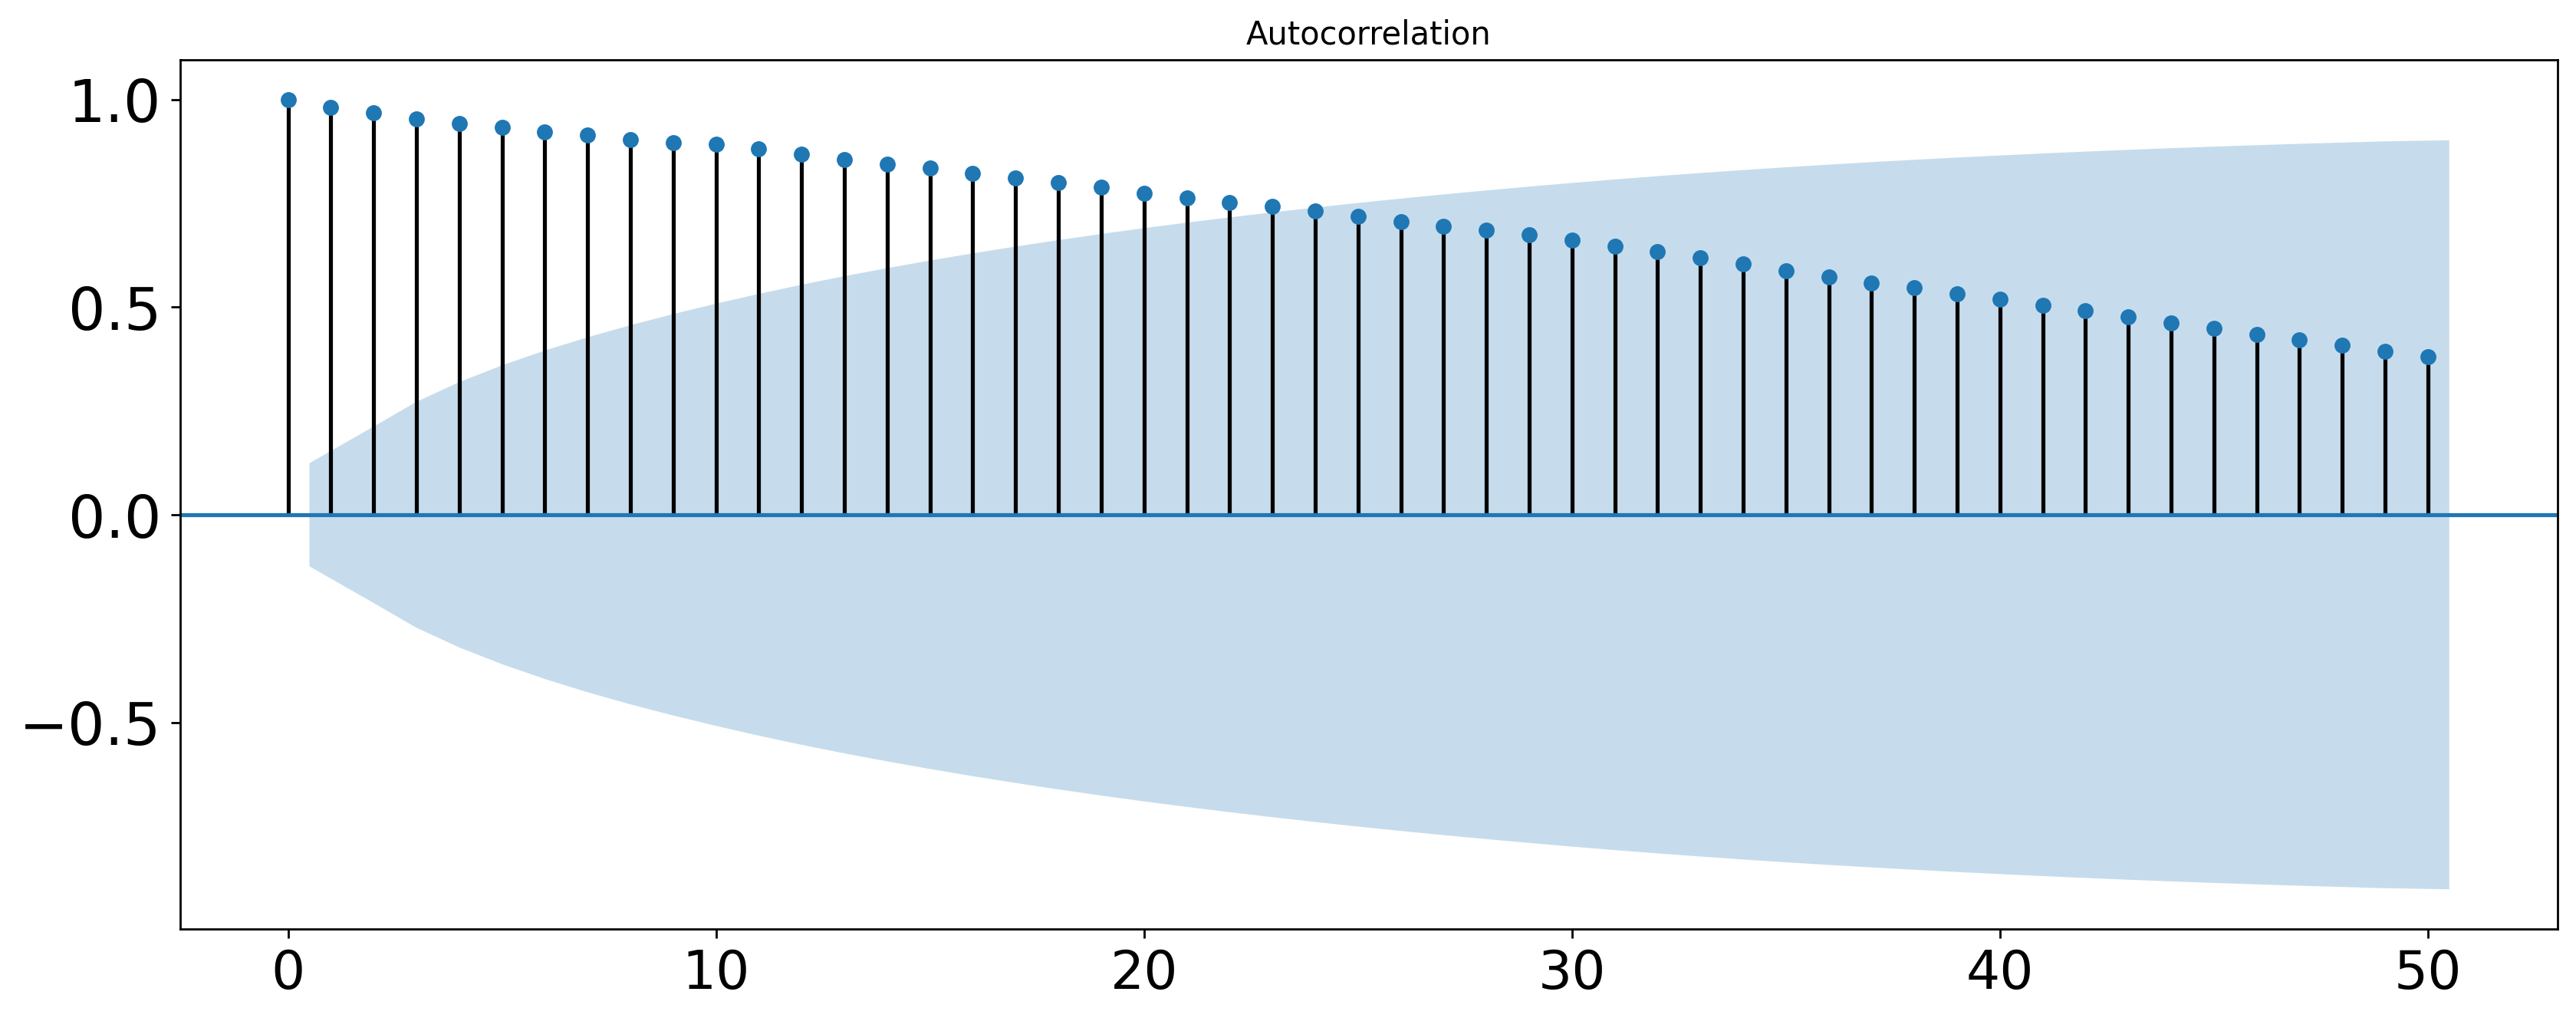

In [123]:
fig = plt.figure(figsize=(16,6),dpi=250)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=22)
ax1=fig.add_subplot(1,1,1)
sm.graphics.tsa.plot_acf(df_stocks['5. adjusted close'], lags=50, ax=ax1)
plt.savefig("plots/autocorr.png")
plt.show()

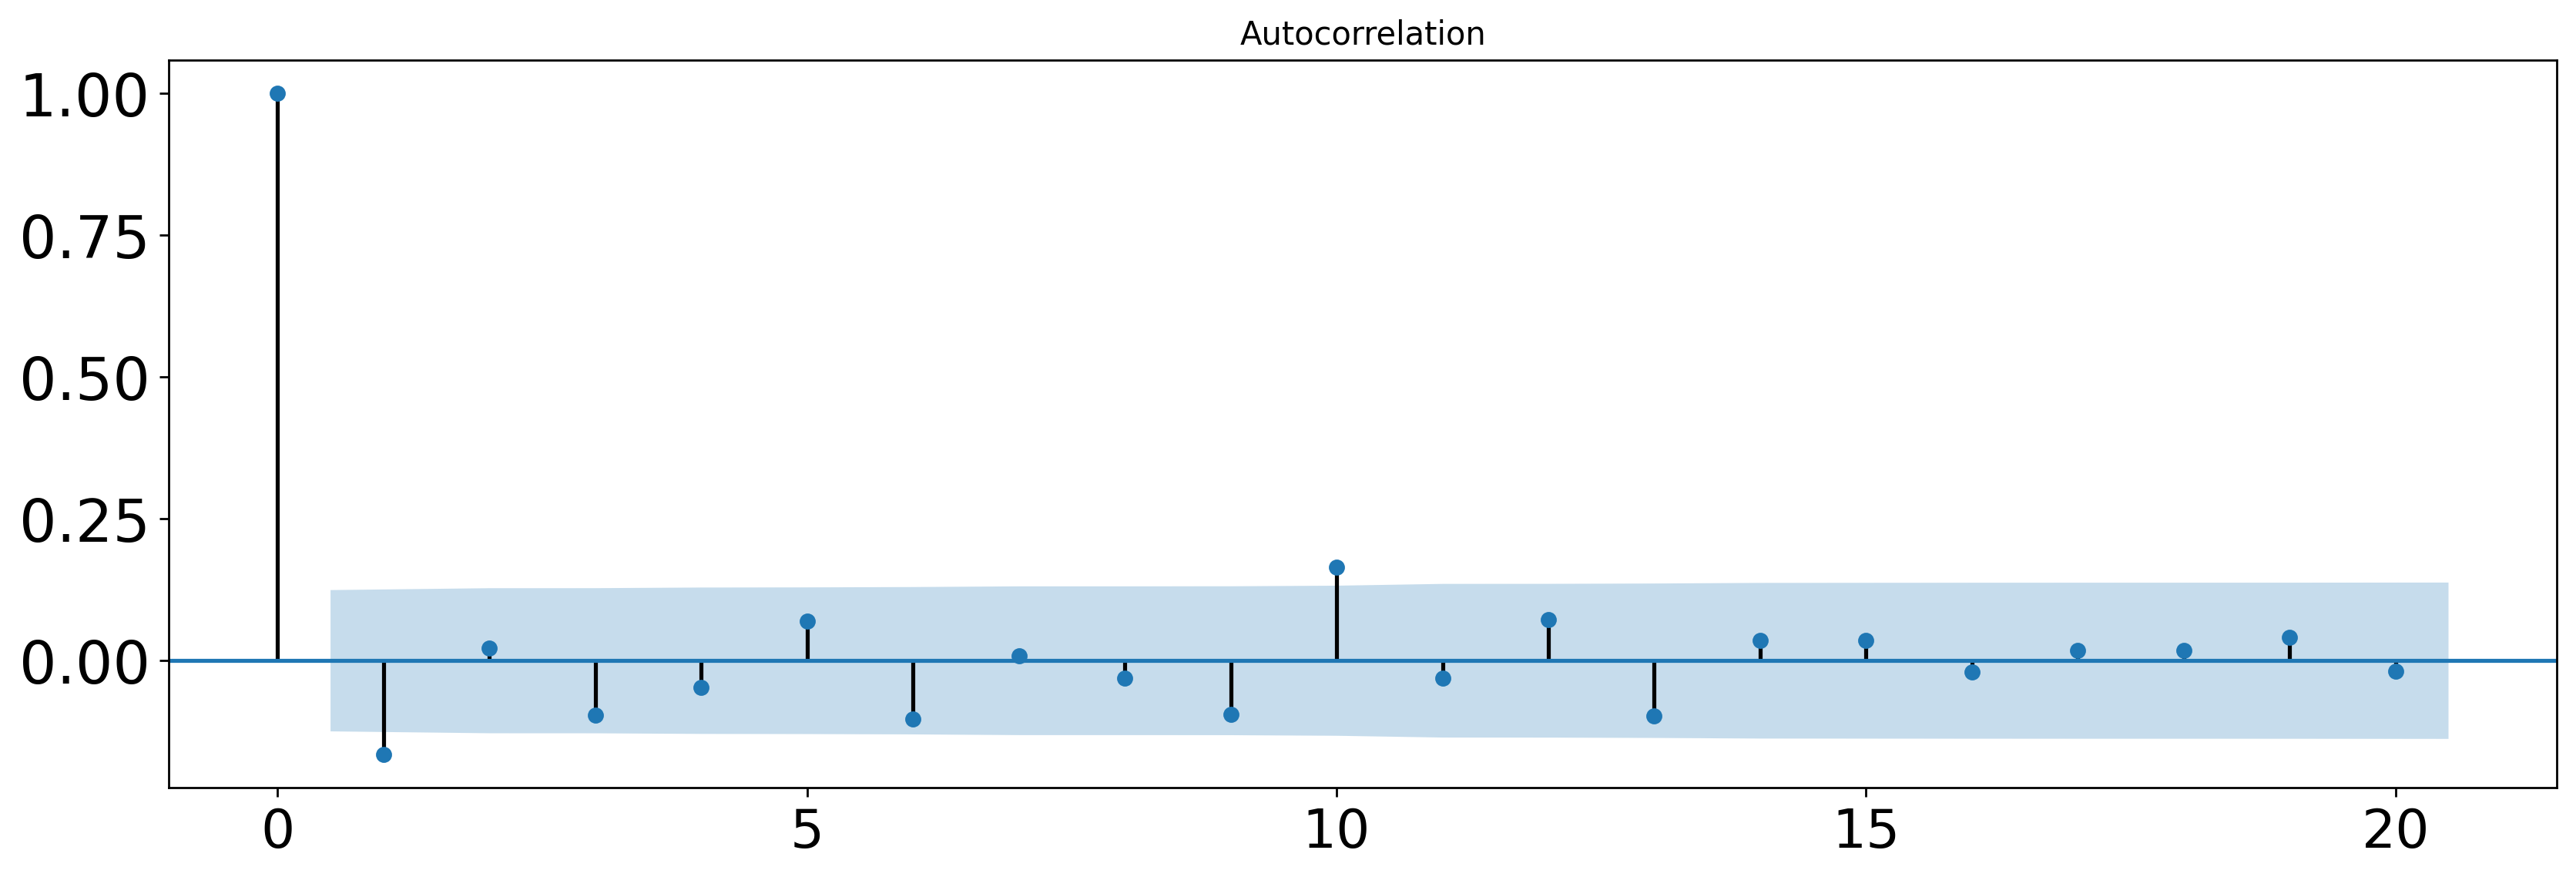

In [117]:
fig = plt.figure(figsize=(16,5),dpi=250)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=22)
ax1=fig.add_subplot(1,1,1)
fig = sm.graphics.tsa.plot_acf(df_stocks['5. adjusted close'].diff().dropna(), lags=20, ax=ax1)
plt.savefig("plots/autocorr_stationary.png")
plt.show()

### The stationarity of the time series is apparent based on the ACF plots

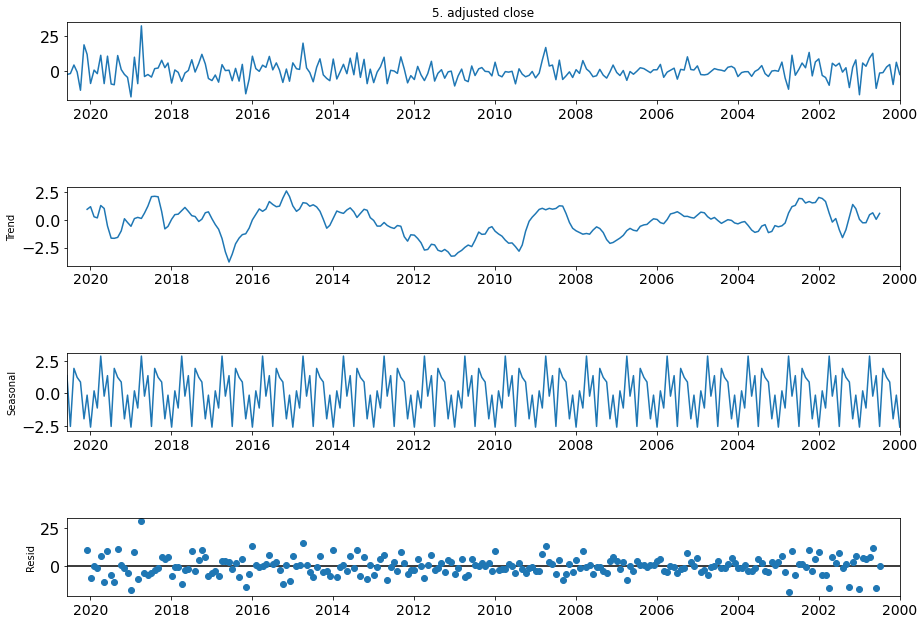

In [469]:
seas_d=sm.tsa.seasonal_decompose(df_stocks['5. adjusted close'].diff().dropna(),model='add',period=12);
fig=seas_d.plot()
fig.set_figwidth(15)
fig.set_figheight(10)
plt.show()

### The stationarity is also apparent when one looks at the trends of the stock prices

In [370]:
#We shift the patent data set by 3 months. The assumption is that new
#technologies are on average introduced every quarter by tech companies.
df_patents_shifted=df_patents_filtered.shift(periods=3, freq="M")
df_patents_shifted.head()

,patent_num_claims,detail_desc_length,patent_num_cited_by_us_patents,patent_num_combined_citations
month_year,,,,
2000-05,5565,7061040.0,14094,3519
2000-06,4558,6504200.0,10252,2740
2000-07,4308,5112308.0,8121,2829
2000-08,6055,6624100.0,15059,3815
2000-09,4163,5816451.0,9048,2636


In [464]:
df_patents_shifted

,patent_num_claims,detail_desc_length,patent_num_cited_by_us_patents,patent_num_combined_citations
month_year,,,,
2000-05,5565,7061040.0,14094,3519
2000-06,4558,6504200.0,10252,2740
2000-07,4308,5112308.0,8121,2829
2000-08,6055,6624100.0,15059,3815
2000-09,4163,5816451.0,9048,2636
...,...,...,...,...
2020-05,14775,0.0,9,23814
2020-06,21052,0.0,3,32765
2020-07,13262,36049403.0,2,19762


In [463]:
patent_features

,patent_num_claims,detail_desc_length,patent_num_cited_by_us_patents,patent_num_combined_citations
month_year,,,,
2000-08,5565,7061040.0,14094,3519
2000-09,4558,6504200.0,10252,2740
2000-10,4308,5112308.0,8121,2829
2000-11,6055,6624100.0,15059,3815
2000-12,4163,5816451.0,9048,2636
...,...,...,...,...
2020-08,14775,0.0,9,23814
2020-09,21052,0.0,3,32765
2020-10,13262,36049403.0,2,19762


In [402]:
df_stocks.index=df_stocks.index.to_period("M")
time_series=df_stocks['5. adjusted close'].loc[df_stocks.index>=min(df_patents_shifted.index)].sort_index(ascending=True)
#We select the data points to be used for the prediction.
train_X, train_y  = time_series[:234],patent_features['patent_num_claims'][:234]
remainder_X=time_series[234:]

In [415]:
pred_y  = patent_features['patent_num_claims'][231:]

In [405]:
#The other benefit of pmdrima is that it is simple to implement 
#stationarity. We do so by setting d = 1 in the code below.
sxmodel = auto_arima(train_X, exogenous=pd.DataFrame(train_y),
                           start_p=1, start_q=1,
                           test='adf',d=1,
                           max_p=10, max_q=10, m=4,
                           start_P=0, seasonal=True,
                           information_criterion='aic', 
                            D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                           )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=1514.457, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=1666.579, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1606.133, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=1511.516, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=1667.256, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=1510.724, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=1603.477, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=1512.503, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=1510.522, Time=0.74 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=1511.471, Time=0.36 sec
 ARIMA(1,1,1)(0,1,2)[4]             : AIC=1515.022, Time=0.79 sec
 ARIMA(0,1,2)(0,1,2)[4]             : AIC=1514.702, Time=0.85 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=1513.127, Time=0.65 sec
 ARIMA(1,1,2)(0,1,2)[4]             : 

In [406]:
#We extract the curve fit from the model to 
#compare to the actual data.
fitted=sxmodel.fit(train_X,pd.DataFrame(train_y))

In [416]:
#Predictions for the final plots
predictions=sxmodel.predict(n_periods=pred_y.shape[0],exogenous=pd.DataFrame(pred_y),return_conf_int=True)

In [417]:
#Upper/lower bounds to establish uncertainities in our computations.
lower=[each[0] for each in predictions[1]]
upper=[each[1] for each in predictions[1]]

In [409]:
predictions[0]

array([130.45558334, 129.07161985, 129.94906317, 129.18001983,
       132.67438181, 129.25447959, 130.89086738, 128.44057793,
       131.28581695, 130.7357894 , 132.29790427, 131.42173651,
       133.13617032, 131.14725969, 133.05536257])

In [418]:
#Now we construct the final plots
data={'period':pred_y.index,'val':predictions[0]}
dataLower={'period':pred_y.index,'val':lower}
dataUpper={'period':pred_y.index,'val':upper}
predictions = pd.DataFrame(data)
predictionsLow = pd.DataFrame(dataLower)
predictionsUp = pd.DataFrame(dataUpper)
predictions.index = predictions['period']
predictionsLow.index = predictionsLow['period']
predictionsUp.index = predictionsUp['period']

In [420]:
fitted=sxmodel.predict_in_sample(pd.DataFrame(train_y))

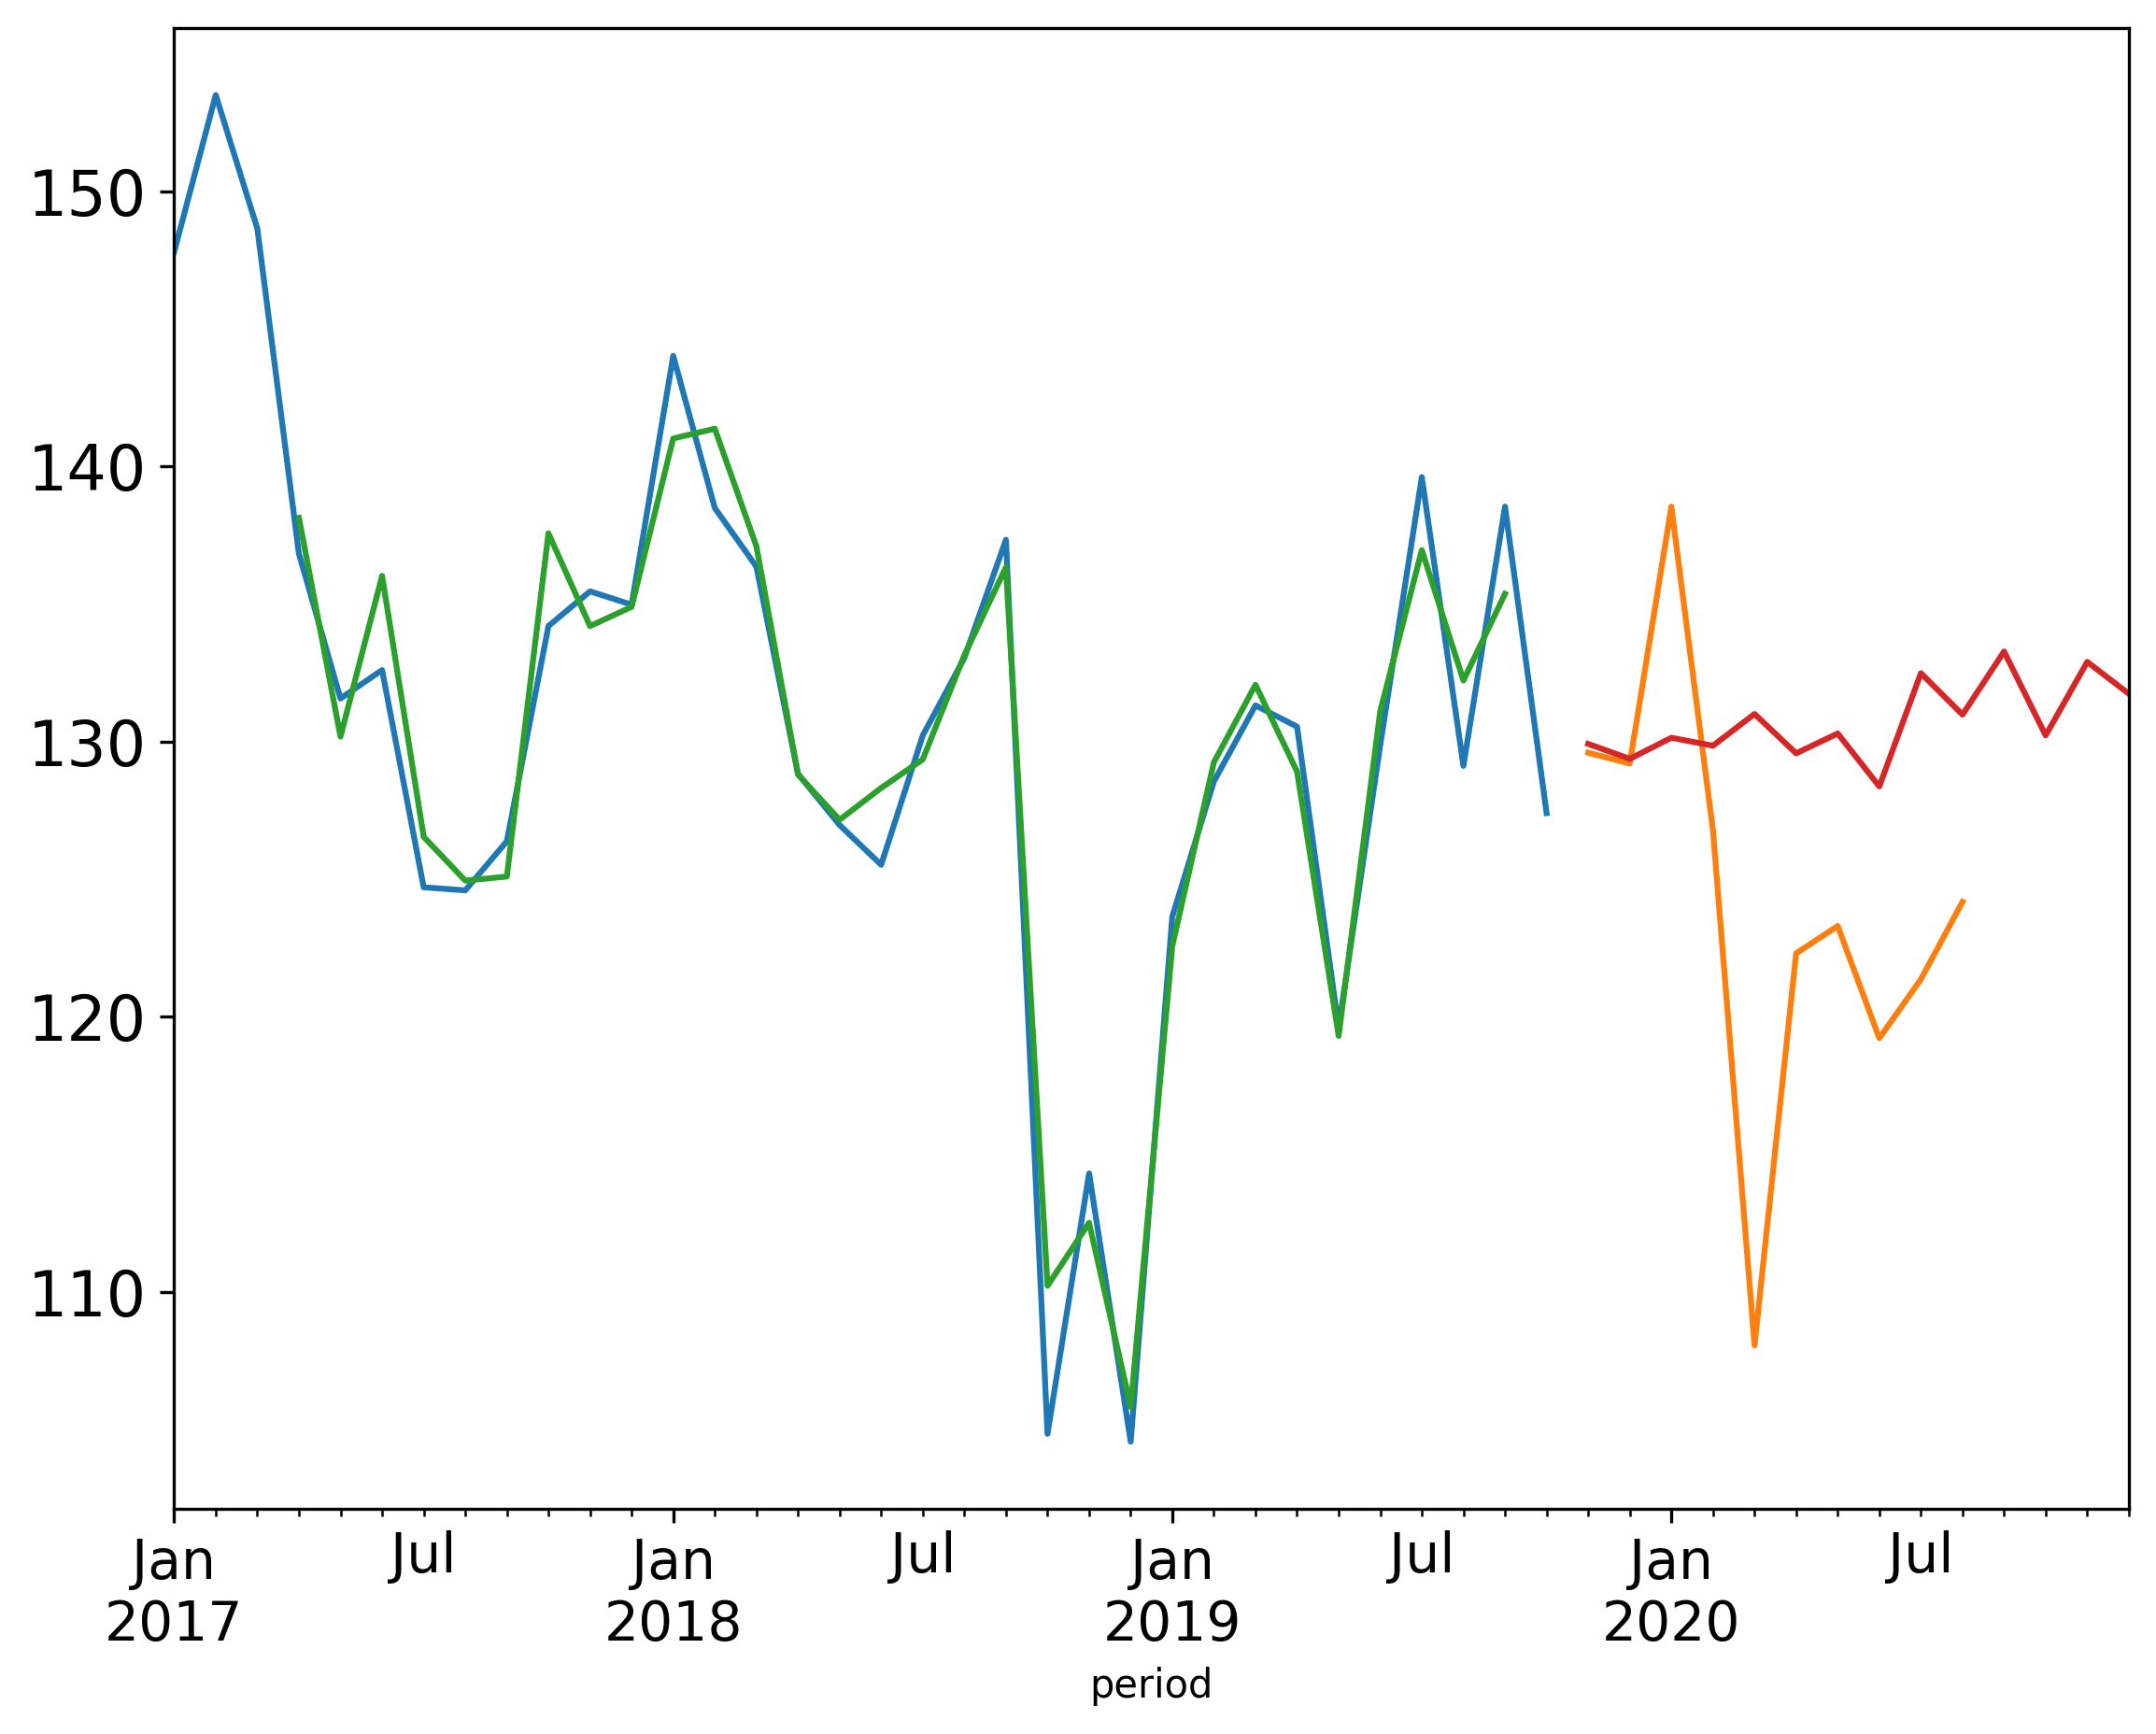

In [421]:
plt.figure(figsize=(9,7), dpi=300)
train_X[200:].plot()
remainder_X.plot()
fitted[200:].shift(-4).plot()
predictions['val'].plot()

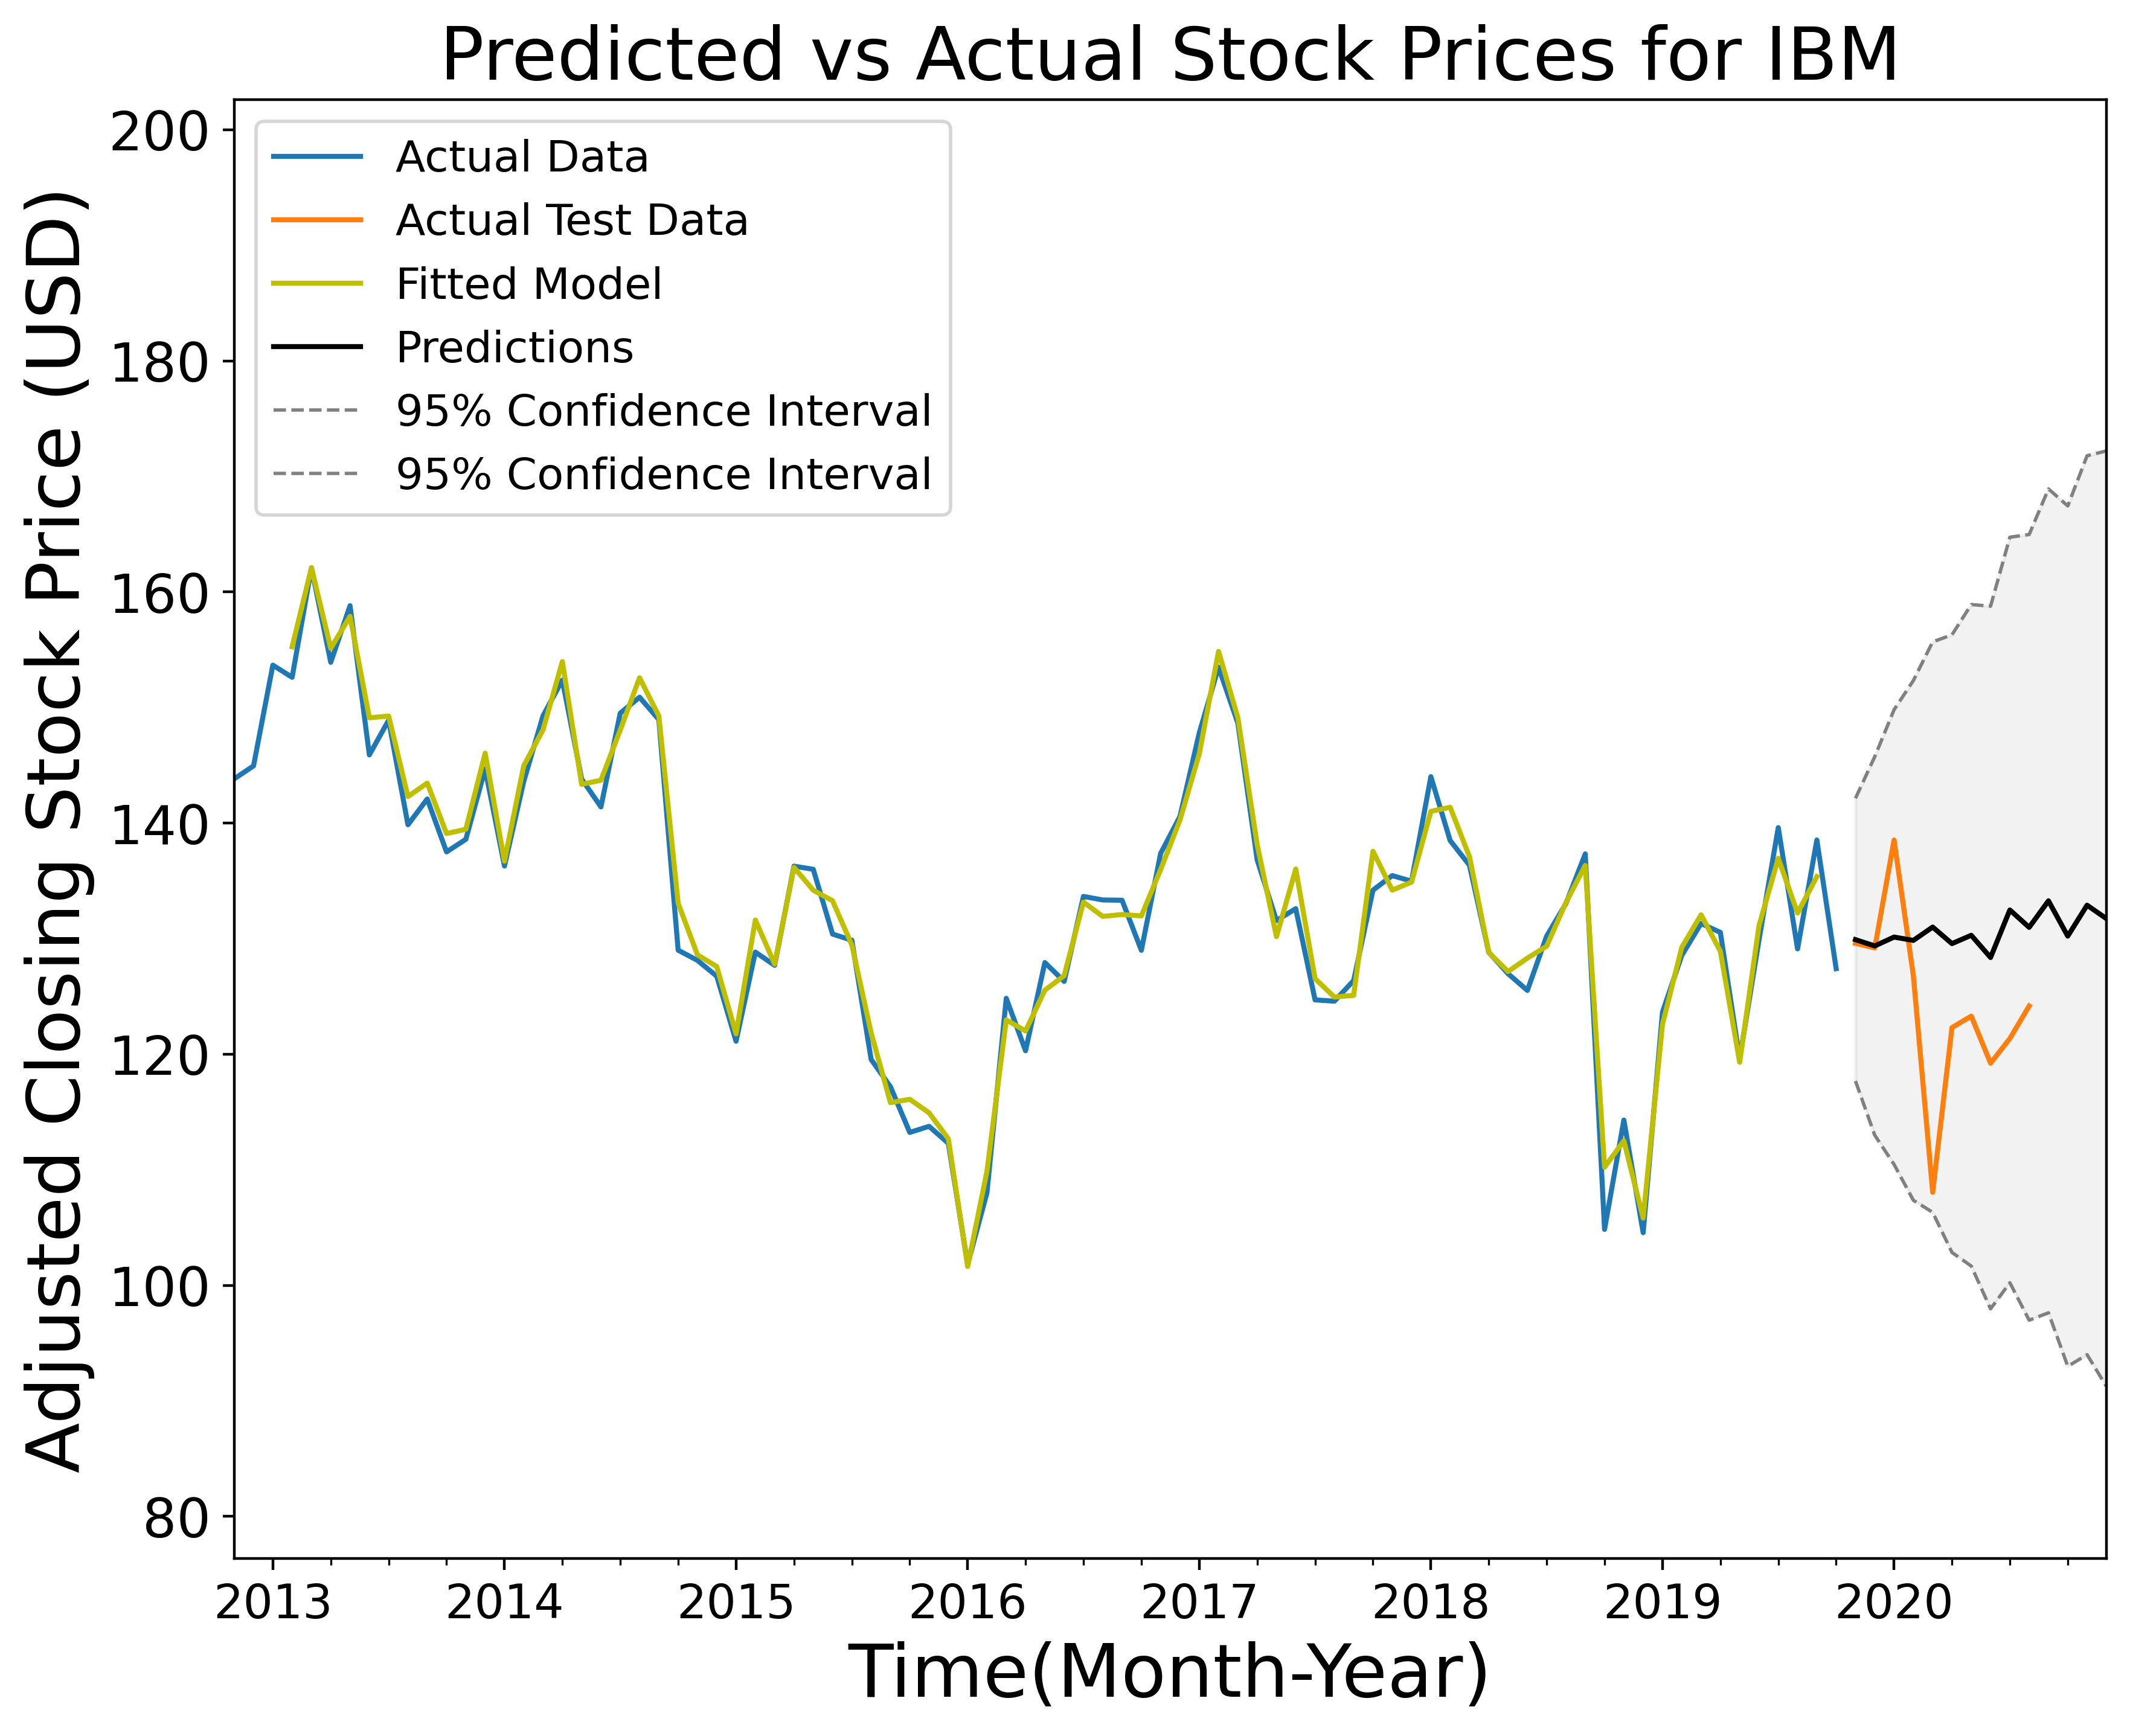

In [462]:
#predictions.index = predictions['period']
#predictionsLow.index = predictionsLow['period']
#predictionsUp.index = predictionsUp['period']
plt.figure(figsize=(10,8), dpi=400)
train_X[150:].plot(label='Actual Data')
remainder_X.plot(label='Actual Test Data')
fitted[150:].shift(-4).plot(label='Fitted Model',color='y')
predictions['val'].plot(label='Predictions',color='black')
plt.fill_between(predictionsUp.index, 
                 predictionsUp['val'], 
                 predictionsLow['val'], 
                 color='gray', alpha=.10)
predictionsUp['val'].plot(label='95% Confidence Interval',linestyle='--', linewidth=1, alpha=1,color='gray')
predictionsLow['val'].plot(label='95% Confidence Interval',linestyle='--', linewidth=1, alpha=1,color='gray')
plt.title("Predicted vs Actual Stock Prices for IBM",fontsize=22)
plt.xlabel("Time(Month-Year)",fontsize=22)
plt.ylabel("Adjusted Closing Stock Price (USD)",fontsize=22)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)
plt.legend(fontsize=13)
plt.ylim(min(train_X[150:])*0.75,max(train_X[150:])*1.25)
plt.plot()
plt.savefig("plots/prediction_ibm.png")